# First Assignment AN2DL

Before the construction of the model, we had to prepare the dataset, in order to set the directory properly for the methods we wanted to use. The validation set was not given, so we have splitted the training set: after many trials we have set the validation split at 0.15, which gave us a consistent prediction during the experiments. The training set was also preprocessed with data augmentation because we wanted to increase the number of images as well as to reduce overfitting.
Before using transfer learning, we have constructed our own network: we have noticed a better performance when we have increased the width of the structure with the depth. With this network we have reached a 0.78 accuracy on the test set. We have regularized the model with dropout (rate=0.1), batch normalization and early stopping (patience=10). 
Afterwards, we wanted to increase model accuracy and reduce the number of trainable parameters. With transfer learning, we have tried different well known networks applying fine tuning. DenseNet and ResNet152v2, after several attempts on the optimal number of layers to block, gave important results: with the first one we have reached 0.8955 accuracy on the test set and reduce consistently the number of parameters. The graphs of validation loss and training loss showed us that overfitting is under control but the accuracy on the training set revealed that the model can improve.
At the end we have tried to consider the two best models (DenseNet and ResNet152v2) together inside the prediction. Of course in this way we have increased the number of parameters, but we have reached 0.9111 of accuracy on the test set.

## Import Library, set Seed and Directory

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
from PIL import Image
from datetime import datetime

In [ ]:
# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)  

### Drive and Folders

Change directory here and put MaskDataset already unzipped in the directory folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory='/content/drive/My Drive/Primo Assignment/'

Mounted at /content/drive


Here we divide the images of the training set into the three classes:

In [ ]:
dir = os.path.join(directory,'MaskDataset/training')

dir_0 = os.path.join(dir, '0')
dir_1 = os.path.join(dir, '1')
dir_2 = os.path.join(dir, '2')
if not os.path.exists(dir_0): os.makedirs(dir_0)
if not os.path.exists(dir_1): os.makedirs(dir_1)
if not os.path.exists(dir_2): os.makedirs(dir_2)

import json
json_path = ""
with open(json_path) as json_file:
    folder_index = json.load(json_file)


def move_file(file_to_move):
    file_name = file_to_move.split(os.path.sep)[-1]
    index = folder_index[file_name]
    new_dir = dir + "/" + f"{index}"
    os.rename(file_to_move, os.path.join(new_dir, file_name))

for entry in os.scandir(dir):
    if (entry.path.endswith(".jpg") or entry.path.endswith(".png")) and entry.is_file():
        move_file(entry.path)

## Image Data Generator

Now we apply the data augmentation and set the size of the validation set:

In [ ]:
# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
apply_data_augmentation = True 
val_split = 0.15

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
valid_data_gen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

if apply_data_augmentation:
  train_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=False, 
                                      fill_mode='constant', 
                                      cval=0,
                                      validation_split=val_split,
                                      rescale=1./255)

In [ ]:
# Create Generators
dataset_dir = os.path.join(directory,'MaskDataset')

num_classes = 3
# Batch size
bs = 64
# Img shape
img_h = 256
img_w = 256

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h,img_w),
                                               batch_size=bs,
                                               classes = None, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)

# Validation
validation_dir = os.path.join(dataset_dir, 'training')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h,img_w),
                                               batch_size=bs, 
                                               classes = None,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='validation',
                                               seed=SEED)

Found 4773 images belonging to 3 classes.
Found 841 images belonging to 3 classes.


In [ ]:
# Creating Dataset
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
train_dataset = train_dataset.repeat()
valid_dataset = valid_dataset.repeat()

## Model Building

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping 
tf.get_logger().setLevel('ERROR')

In [ ]:
# Inizialization
now = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'CNN'
callbacks = []

### Model Layers

These are the main networks we have used. We have also tried to use MobileNet and NasNetLarge , but with poor results.


In [ ]:
def build_layers(architecture, freeze, rate, transfer):

    # Building of various famous architectures
    if transfer:

        model = Sequential()

        if (architecture == "resnet"):
            arch = tf.keras.applications.resnet_v2.ResNet152V2(weights='imagenet', 
                                                               classes=num_classes, 
                                                               input_shape=(img_h, img_w, num_classes),
                                                               include_top=False)
            for layer in arch.layers[:freeze]:
                layer.trainable = False

        if (architecture == "inception"):
            arch = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
                                                                  classes=num_classes, 
                                                                  input_shape=(img_h, img_w, num_classes),
                                                                  include_top=False)
            for layer in arch.layers[:freeze]:
                layer.trainable = False

        if (architecture == "densenet"):
            arch = tf.keras.applications.densenet.DenseNet201(weights='imagenet',
                                                              classes=num_classes, 
                                                              input_shape=(img_h, img_w, num_classes),
                                                              include_top=False)
            for layer in arch.layers[:freeze]:
                layer.trainable = False

        if (architecture == "inceptionresnet"):
            arch = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', 
                                                                               classes=num_classes, 
                                                                               input_shape=(img_h, img_w, num_classes),
                                                                               include_top=False)
            for layer in arch.layers[:freeze]:
                layer.trainable = False

        # Adding the last part of the layers
        model.add(arch)
        model.add(GlobalAveragePooling2D(data_format=None)) #we have seen that GAP is a good strategy to reduce the number of parameters and keep
                                                            #high accuracy 
        model.add(Dropout(rate))
        model.add(Dense(num_classes, activation='softmax'))
        model.summary()
    # Building our architecture
    else:

        if(architecture == "manual1"):
            rate = 0.1
            model = Sequential([
                Conv2D( 16, (3,3), activation = "relu", input_shape=(256,256,3)),
                MaxPooling2D((2,2)),
                Conv2D( 32, (3,3), activation = "relu"),
                MaxPooling2D((2,2)),
                Conv2D( 64, (3,3), activation = "relu"),
                MaxPooling2D((2,2)),
                Conv2D(128, (3,3), activation = "relu"),
                MaxPooling2D((2,2)),
                Conv2D(256, (3,3), activation = "relu"),
                MaxPooling2D((2,2)),
                Conv2D(512, (3,3), activation = "relu"),
                MaxPooling2D((2,2)),
               
                Flatten(),
                BatchNormalization(),
                Dense(512, activation="relu"),
                Dropout(rate, seed=SEED),
                Dense(512, activation="relu"),
                Dropout(rate, seed=SEED),
                Dense(num_classes, activation = "softmax")
])

    return model

### Model Compiling

In [ ]:
def build_optimization(model, lr):

    # Optimization parameters
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    metrics = ['categorical_accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [ ]:
def build_callbacks(early_stop):
  
    callbacks = []

    # Checkpoint directory creations
    exps_dir = os.path.join(directory, 'classification_experiments')
    if not os.path.exists(exps_dir): os.makedirs(exps_dir)
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists( exp_dir): os.makedirs(exp_dir)
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir): os.makedirs(ckpt_dir)
    best_dir = os.path.join(ckpt_dir, 'best.h5')
    callbacks.append(ModelCheckpoint(filepath=best_dir, save_best_only=True, verbose = 2))

    # Early Stopping
    if early_stop:
      callbacks.append(EarlyStopping(monitor='val_loss', patience=10)) #Set for the training with 100 epochs together.
                                                                       #Patience reduced from 10 to 5 when the model was trained repeating 10 epochs  
                                                                       #and using model checkpoint.
    # Introducing a lr adapter. We have seen that this works well reducing the time for convergence. 
    lr_adapter_callback = ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.2, 
                                            patience=3, 
                                            verbose=1, 
                                            mode='auto', 
                                            min_delta=0.0001, 
                                            cooldown=0)
    callbacks.append(lr_adapter_callback)

    return (callbacks,best_dir)


## Model Training

### Model Fit

In [ ]:
def build_fit(model, callbacks, ep):
    history = model.fit(x = train_dataset, 
                        epochs=ep,
                        steps_per_epoch=len(train_gen),
                        validation_data=valid_dataset,
                        validation_steps=len(valid_gen),
                        callbacks=callbacks)
    return history

### Training Graphics

In [ ]:
def training_graphics(history):
    frame = pd.DataFrame(history.history)

    acc_plot = frame.plot(y="categorical_accuracy", title="Accuracy vs Epochs", legend=False)
    acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

    acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
    acc_plot.set(xlabel="Epochs", ylabel="Loss")

    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Regularised model: loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

## Model Run

### Model Creation

In [ ]:
def model_run(architecture, freeze, ep, transfer):

    # Parameters
    lr = 5e-4
    rate = 0.5
    early_stop = True

    # Model Building
    model = build_layers(architecture, freeze, rate, transfer)
    model = build_optimization(model, lr)
    [callbacks, best_dir] = build_callbacks(early_stop)
    history = build_fit(model, callbacks, ep)
    #training_graphics(history)

    return (model, best_dir, history)

### Models Creations

Now we are creating a dictionary in which the keys are the names of our best models:

In [ ]:
models={}
models["resnet"] =list( model_run("resnet", 285, 100, True))
models["resnet"][0]=load_model(models["resnet"][1]) #here we are using the best model saved with model_checkpoint
models["densenet"] = list(model_run( "densenet", 350, 100, True))
models["densenet"][0]=load_model(models["densenet"][1])

In [ ]:
models["resnet"][0]("val_categorical_accuracy")

GRAPHICS OF RESNET


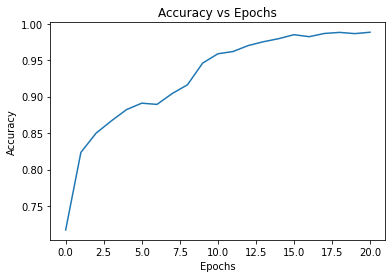

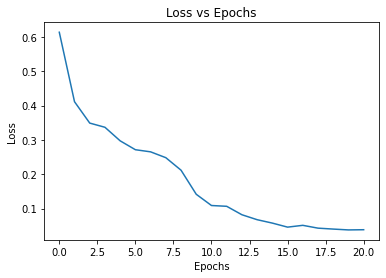

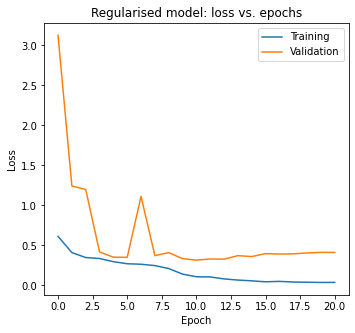

GRAPHICS OF DENSENET


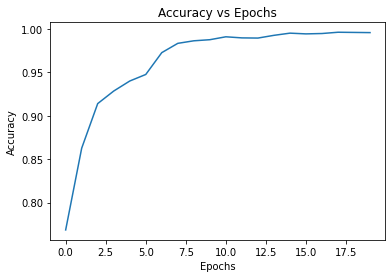

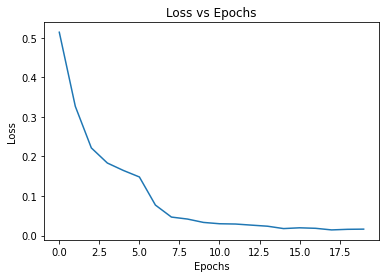

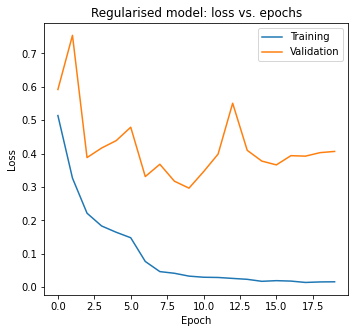

In [ ]:
print("GRAPHICS OF RESNET")
training_graphics(models["resnet"][2])
print("GRAPHICS OF DENSENET")
training_graphics(models["densenet"][2])

## Test Set and CSV

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
dir = os.path.join(directory,'MaskDataset/test')
csv_dir = os.path.join(directory,'csv')

image_filenames = next(os.walk(dir))
results = {}

for image_name in image_filenames[2]:
    img_path = os.path.join(dir,image_name)
    img = Image.open(img_path).convert('RGB')
    
    img = img.resize((256,256))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array = img_array/255

    predictions = np.array([[0, 0, 0]], dtype = "float32")
    
    for key in models:
      
      predictions += models[key][0].predict(img_array) #we are summing the predictions obtained from the different models
    results[image_name] = np.argmax(predictions)       #we take the index corresponding to the argmax of the predictions

create_csv(results, csv_dir)